---
title: "Usage Instructions and Documentation"
format:
  html:
    code-fold: true
jupyter: python3
execute: 
  enabled: false
  eval: false
---

# Introduction

This notebook documents the Traffic Density Index (TDI) analysis workflow. <p> The process uses medium spatial-resolution PlanetScope imagery to detect image pixels likely to contain vehicles. 
This work was heavily inspired by the following paper:<br> 
- Chen, Y., Qin, R., Zhang, G., & Albanwan, H. (2021). Spatial Temporal Analysis of Traffic Patterns during the 
COVID-19 Epidemic by Vehicle Detection Using Planet Remote-Sensing Satellite Images. Remote Sensing, 13(2), Article 2. 
<a href="https://doi.org/10.3390/rs13020208">https://doi.org/10.3390/rs13020208t</a>

The workflow is run using the following two notebooks found in the `notebooks/tdi` folder in this repository:
- [skywatch-api-notebook.ipynb](skywatch-api-notebook.ipynb)
- [tdi-notebook.ipynb](tdi-notebook.ipynb)

The `skywatch-api-notebook` is run first, and is used to query and download PlanetScope images for a desired area-of-interest (AOI) and time-of-interest (TOI).<p>

Once the images have been downloaded, the `tdi-notebook` is run to generate the TDI outputs.

# Python Environment Setup

Before doing anything, the Python environment needs to be set up. The recommended method to build the environment is to use Anaconda 
(use of <a href="https://mamba.readthedocs.io/en/latest/installation.html">Mamba</a> is strongly recommended as it is much faster at building the environment than regular Anaconda).<p>

To build the environment:
- Open a new terminal in the `notebooks` folder
- Using mamba, enter the following command into the terminal: 
    - `mamba env create --name wb-spk-env --file environment.yml`

To activate the new python environment, enter the following command into the terminal: 
- `mamba activate wb-spk-notebook-env`

# Notebook 1: skywatch-api-notebook

## Initial Setup

There is some initial work required by the user prior to running the notebook. This initial work includes:
- Retrieve an API key from the Skywatch Earthcache <a href="https://console.earthcache.com/account">website</a>.
- Create a polygon file which outlines the image download AOI.
    - This can be created in any standard desktop GIS program (i.e. QGIS/ArcGIS) and must be in a format readable by the <a href="https://geopandas.org/en/stable/docs/user_guide/io.html">geopandas</a> package (i.e. geopackage, shapefile, geojson).
    - The Earthcache API allows retrieved images to be cropped to complex geometry, and this is a good way to reduce image download costs by only selecting the areas needed. However, it is recommended to include some buffer around the areas of interest to avoid missing important data due to image georegistration shifts.
    - Note that for the Beitbridge study AOI, a geometry file has been created already, located [here](../../data/processed/Beitbridge_PS_AOI_Final.gpkg).

## Input Query Parameters

Open Jupyter Lab by typing `jupyter lab` into the terminal. Inside Jupyter Lab, navigate to and open `skywatch-api-notebook.ipynb`.<p>
At the top of the notebook (2nd code cell), specify the following variables:
- Put your Earthcache API key in the `api_key` variable.
- Set the `aoi_name` variable. This is the name of the area of interest, and will be appended to the file names for various files output by the program.
- Set the `o_start_date` variable to the starting date for the image download query. Formatted as a string in the format `"YYYY-MM-DD"`.
- Set the `o_end_date` variable to the ending date for the image download query. Formatted as a string in the format `"YYYY-MM-DD"`.
- Set the `cc_thresh` variable to the desired cloud cover threshold to use for the query. Images with a cloud cover percentage exceeding this threshold will be omitted from the returned query results.
    - Note: prior to image download it is possible to use a more stringent cloud cover threshold. Therefore it is fine to use a higher value in `cc_thresh` for the initial query.
- Set the `coverage_thresh` variable to the desired aoi coverage percentage. Images which cover less of the AOI than the specified threshold will be omitted from the returned query results.
    - Note: at a later stage in the notebook it is possible to use a more stringent aoi coverage threshold. Therefore it is fine to use a higher value in `coverage_thresh` for the initial query.
- Set `output_graphs` to `True` to output files for the graphs generated in Stage 3. Otherwise keep the default setting of `False`
- Set the `aoi_file` variable to the path to the geometry file created in the [Initial Setup](#initial-setup) section.
- Set the `out_path` variable. All outputs from the program will be nested under this directory.
- If desired, change other variables including the `outpath_search_df`, `outpath_download_df`, and `outpath_images`, or leave as the default settings.

## Stage 1: Search API

The first stage of the notebook queries the Earthcache API using the specified AOI and TOI and returns the search results.<p>

For larger time periods, the API may not return full results. To compensate for this, time intervals longer than 90 days are split into separate queries. At the end of the process, the separate queries are put back together.<p> 

The image results are stored in a [pandas](https://pandas.pydata.org/) dataframe. This dataframe is then serialized into a [pickle file](https://docs.python.org/3/library/pickle.html), allowing the results to be retrieved if the notebook is shut down and resumed later.

## Stage 2: Filter Query DataFrame

In the first stage, all image results which cover at least 50% of the AOI and are within the TOI are returned. This includes images with up to 100% cloud cover, and may include multiple images on a specific date.<p>

In stage 2, the results are filtered down based on the AOI coverage and cloud coverage thresholds specified in the `coverage_thresh` and `cc_thresh` variables.<p>

Finally, if multiple images are present on a given day, a selection function is applied to pick the "best" image for the day. The selection criteria is as follows:
- If any of the images have significantly lower AOI coverage than the others, they are removed.
- If there are still multiple images remaining, the program checks if any of the images are from the Dove-R or SuperDove satellites, as these are superior to the original Dove-Classic satellites. If this is the case, then any Dove-Classic scenes are removed.
- If there are *still* multiple images remaining, then the program simply takes the one with the highest AOI coverage.

The filtered dataframe is once again serialized into a pickle file, allowing the notebook to be shut down and resumed later.

## Stage 3: Graph Generation

In this stage, a number of interactive graphs may be generated to allow the user to explore and visualize the returned query results.<p>

For example, the below figure displays the number of images per year for a test AOI at different levels of cloud cover, along with the estimated cost to download all the images.

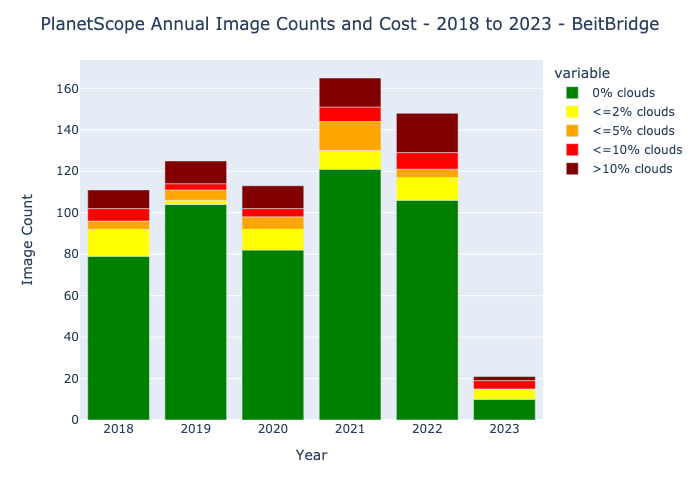

In [4]:
#| echo: false
from IPython.display import Image
from pathlib import Path
Image(filename=Path("../../data/tdi_demo_files/Beitbridge/search_queries/figures/PlanetScope_Annual_Image_Count_and_Cost_2018_to_2023_BeitBridge.png"))

While this stage is optional, it is helpful to understand the query results, and can be informative for the final image selection criteria to be used for image downloading.

## Stage 4: Download Imagery

The last stage of this notebook is used to download the images. It is possible to specify different download criteria for downloading images than used in the original query. For instance, a narrower date range can be specified, a more strict cloud cover or aoi coverage threshold can be used, or only select sensor types can be downloaded. Otherwise, the original query criteria can also be used for downloading the images. The following parameters can be set by the user in Stage 4<p>
- `start_date_download`: Starting date for image downloading. Formatted as a string in the format `"YYYY-MM-DD"`. If set to `None`, the value for `o_start_date` specified at the beginning of the notebook is used.
- `end_date_download`: Ending date for image downloading. Formatted as a string in the format `"YYYY-MM-DD"`. If set to `None`, the value for `o_end_date` specified at the beginning of the notebook is used.
- `max_cc_download`: Cloud cover percentage threshold for image downloading. If set to `None`, the value for `cc_thresh` specified at the beginning of the notebook is used.
- `aoi_coverage_download`: Image aoi percent coverage threshold for image downloading. If set to `None`, the value for `coverage_thresh` set at the beginning of the notebook is used.
- `sat_list`: List of satellite types to download. Options are `[dove-c, dove-r, superdove]`. If set to `None`, all 3 types are selected.

Once the final selection criteria is specified, the imdage dataframe is filtered down, and the program displays the total number of images to download and the total cost as shown below:

`Total number of images to download: 90. Total cost: $676.67 USD`

***Warning: Continuing with the image download in the next steps will incur the outlined costs. There is no safety mechanism or warning message. Proceed with caution.***<p>

Images are downloaded using the API by setting up image download "pipelines". Each image will create a unique pipeline, which will show up in the Earthcache online dashboard. The pipeline kicks off image retrieval and processing, which is required before the images can be downloaded. Note that once a pipeline is created, you will be billed for the images, even if you do not download them locally.<p>

Image download proceeds as follows:
- Image download pipelines are created for each image in the filtered dataframe. The IDs for each pipeline are appended to the dataframe.
- The dataframe with the appended pipeline IDs is saved to a pickle file, allowing it to be retrieved in case the notebook session terminates.
- Each pipeline may take up to an hour to finish processing. The program will loop through the pipelines and check their status. If some pipelines are still processing, the program waits for up to 30 minutes then repeats the process. This loop repeats using progressively smaller intervals until all pipelines achieve a "completed" status.
- Once all image pipelines are finished processing, the next step downloads the images locally. Both the image file and associated metadata are downloaded and placed in a directory named after the image ID.

The first notebook is now finished, and you may move on to the second notebook to generate the TDI outputs.

## File Outputs

This section provides some examples of folders and files output by the program. What is illustrated here assumes the subfolders `outpath_search_df`, `outpath_download_df`, and `outpath_images` are left to their default settings.

<pre>
<b>out_path</b>
│
└───<b>search_queries</b>
│   │
│   └───<i>{aoi_name}_{o_start_date}_to_{o_end_date}_search_df.pkl</i>
│   │       Serialized file containing image search dataframe
│   │
│   └───<b>figures</b>
│       │
│       └───<i>PlanetScope_Annual_Image_Count_and_Cost_{start_year}_to_{end_year}_{aoi_name}.html</i>
│       │       Interactive plot
│       └───<i>PlanetScope_Annual_Image_Count_and_Cost_{start_year}_to_{end_year}_{aoi_name}.png</i>
│               Static plot
│
└───<b>download_dataframes</b> 
│   │
│   └───<i>{aoi_name}_{start_date_download}_to_{end_date_download}_download_df.pkl</i>
│           Serialized file containing image download dataframe
│
└───<b>images</b>
    │
    └───<i>{aoi_name}_{start_date_download}_to_{end_date_download}</i>
        │
        └───<b>{Image_ID_1}</b>
        │   └───<i>{Image_ID_1}_analytic.tif</i>
        │   │       Image file
        │   └───<i>{Image_ID_1}_metadata.json</i>
        │           Image metadata file
        │
        └───<b>{Image_ID_2}</b>
            └───<i>{Image_ID_2}_analytic.tif</i>
            └───<i>{Image_ID_2}_metadata.json</i>
        ...
</pre>

# Notebook 2: tdi-notebook

## Initial Setup

As with Notebook 1, there is some initial work required prior to running Notebook 2.<p>

Firstly, if images were downloaded in multiple batches (i.e. multiple date ranges were used), then all downloaded images must be placed under a common directory. It is alright if images are nested in various sub-directories, as long as all of the sub-directories are located under a common base directory. For example:
<pre>
<b>images</b>
│
└───<b>query_1</b>
│   │
│   └───<b>q1_subfolder_1</b>
│   │   └───<i>q1_image1.tif</i>
│   └───<b>q1_subfolder_2</b>
│   │   └───<i>q1_image2.tif</i>  
│   │   ...
│   ...
│   
└───<b>query_2</b>
│   │
│   └───<b>q2_subfolder_1</b>
│   │   └───<i>q2_image1.tif</i>
│   └───<b>q2_subfolder_2</b>
│   │   └───<i>q2_image2.tif</i> 
│   │   ...
│   ...
...
</pre>

Secondly, the pickle files containing the image download dataframes created in Stage 3 of Notebook 1 must be in a common directory together. These contain the image information corresponding to your downloaded images. For example:

<pre>
<b>download_dataframes</b>
│
└───<i>query_1_dataframe.pkl</i>
│
└───<i>query_2_dataframe.pkl</i>
│
└───<i>query_3_dataframe.pkl</i>
</pre>

Lastly, a geometry polygon file must be created which outlines the roads and parking areas in the AOI within which the vehicles will be counted. Unlike the polygon file used for image downloading, this geometry file should be more narrow and specific to the desired detection areas, to reduce the issue of false positives.<p>

For the Beitbridge study area, an example geometry file has been created already, located [here](../../data/processed/beitbridge_road_mask.gpkg).

## Setting Run Parameters

In Jupyter Lab, navigate to and open `tdi-notebook.ipynb`.<p>
At the top of the notebook (2nd code cell), the run variables may be specified. Some must be set by the user, while others can be left set to the default settings.<p>
- `aoi_name`: Name of the area of interest. Should match the AOI name used in Notebook 1. This name will be appended to certain files output by the program. This must be set by the user.
- `out_path`: Path to the top-level directory for the project. All other folders and files will be nested under this folder. This must be set by the user.
- `road_geom_file`: Path to the road and parking area geometry file. This must be set be the user.
- `img_path`: Path to the directory containing the image files. By default it is set to a folder named `images` which is nested under the `inpath` directory. Leave set to default or change if desired.
- `img_df_path`: Path to the directory containing the image download dataframes. By default it is set to a folder named `download_dataframes` which is nested under the `inpath` directory. Leave set to default or change if desired.
- `outpath_aligned`: Path where the co-aligned images in Stage 1 will be placed. The default path is a folder called `processed_images` which is nested under `inpath`. Leave set to default or change if desired.
- `outpath_tdi`: Directory where the generated TDI outputs will be placed. The default path is a folder called `tdi_outputs` which is nested under `inpath`. Leave set to default or change if desired.
- `band_subset`: Determines whether the vehicle detection algorithm uses all image bands or just the visible Blue, Green, Red, and the Near-Infrared band (BGRN). Options are `allbands` to use all of them, or `4band` to use only the BGRN bands. Note that this option only impacts 8-band SuperDove images. Dove-Classic and Dove-R sensors only have 4 bands, so both options are equivalent. If using images from multiple sensor types, set this option to `4band` for consistency. Default setting is `allbands`.
- `kernel_size`: Size (in pixels) of the kernal used by the tophat filtering process. Options are `3`, `5`, and `7`. Default value is `7`. Using a smaller kernel size reduces the size of the detected objects, which may reduce false positive detections at the cost of reducing true positives as well. Leave set to default or change if desired.
- `sieve_thresh`: Minimum object size (in pxels). Groupings of vehicle detection pixels smaller than the threshold are removed. Useful to reduce noise in the detection layers. Leave set to default or change if desired.
- `min_thresh`: Minimum threshold to apply to tophat filter layers for vehicle detection. During the vehicle detection stage, the program applies iteratively smaller thresholds to the tophat filtered layers until it reaches the threshold value specified here. Default value is `0.015`. Using a larger threshold will reduce both true-positive and false-positive detections, while using a smaller threshold will have the opposite effect. Default value is `0.015`. Leave set to default or change if desired.

## Stage 1: Align Images

In the first stage of the process, the PlanetScope images are all resampled so their pixels all line up through time. It was discovered through examining the images that the data downloaded directly from the Skywatch API can have small pixel misalignments from image to image.<p>

This analysis workflow requires all pixels from each image to be perfectly aligned, which is what this stage accomplishes.<p>

The aligned images are placed in the folder specified in the `outpath_aligned` variable.

## Stage 2: Computing Reference Median Image

In the second stage of the program, a reference image is created. This reference image is used for vehicle detection in Stage 3.<p>

The `reference image` is the pixel-wise and band-wise median calculated from the full Planetscope image time series. The result from this process is a synthetic image with the same number of pixels and bands as the original images, where each pixel contains the median band values for that pixel location over the entire time series.<p>

The median `reference image` is used to represent a "vehicle-free" view of the roads and parking lots in the AOI. Since vehicles are mobile assets, their locations are expected to differ from image to image. Therefore over a long enough time series, the median value should represent the invariant features in the images, i.e. the underlying pavement. Please refer to the paper cited in the [Introduction](#introduction) for more details.<p>

***Important Caveat:*** *Since the assumption for the `reference image` is that non-vehicle pixels are unchanging, any major, long-term changes to the roads and parking areas (such as construction) may lead to this assumption being violated. Therefore it is recommended to limit the range of dates covered by the images in any given run, such as processing images in batches of 1 year or 6 month intervals.*

## Stage 3: Tophat Filtering, Vehicle Detection, & Computing TDI

In the final stage of the process, the image analysis and vehicle detection is performed, and the TDI is calculated.<p>

The core of the process is based on subtracting a target image from the generated median `reference image`, then applying a multi-directional tophat filter to extract small objects from the calculated difference image. To learn more about the process, refer to the paper cited in the [Introduction](#introduction), or see [here](https://en.wikipedia.org/wiki/Top-hat_transform).<p>

The program iterates through all images in the time series, applying the following processes:
1. Each image band is subtracted from the corresponding band in the `reference image`. This creates the `difference image`.
2. A multi-directional tophat filter is applied to each image band in the `difference image`. This creates the `multi-band tophat image`.
3. A `single band tophat image` is generated by taking the maximum value across all bands in the `multi-band tophat image`.
4. A thresholding method is applied to the `single band tophat image`, creating the `vehicle detection image`. Pixels with a tophat value exceeding the threshold are given a value of `1` in the `vehicle detection image`, indicating a detection, while pixels with tophat values less than the threshold are given a value of `0`, indicating no detection. The `min_thresh` variable determines the sensitivity of the vehicle detection thresholding.
5. Groupings of detection pixels in the `vehicle detection image` assigned a value of `1` are sieved. Detection pixels bordering other detection pixels are grouped together into objects, and the number of pixels in each are counted. Objects containing less pixels than the value specified in the `sieve_thresh` variable are removed, with all pixels being reassigned a value of `0`.
6. The `vehicle detection image` is masked using the `road_geom_file` polygons. Any pixels outside the polygons are masked out and assigned a value of `0`. We will refer to this image as the `masked detection image`.
7. The `Traffic Density Index (TDI)` is calculated from the `masked detection image` as follows:
$$TDI_i = {{N_{(v, i)}\over  N_{(r, i)}} * S}$$
Where ${N_{(v, i)}}$ is the total number of detection pixels in the `masked detection image` for PlanetScope image $i$, ${N_{(v, i)}}$ is the total number of unmasked pixels for PlanetScope image $i$, and $S$ is a scale factor to avoid numerically small `TDI` values (currently set to $S = 100$).<p>

After the `TDI` has been calculated for all images, the TDI values are appended to the image dataframe, and the dataframe is output as a CSV file which contains image information as well as the corresponding TDI values for each.<p>

As a final step in the process, a time series graph showing `TDI` over time can also be generated.

## File Outputs

This section provides some examples of folders and files output by the program. What is illustrated here assumes the output subfolder names are left as their default path.

<pre>
<b>out_path</b>
│
└───<b>processed_images</b>
│   │
│   └───<i>{Image_ID_1}_aligned.tif</i>
│   │       Co-aligned image file
│   │
│   └───<i>{Image_ID_2}_aligned.tif</i>
│   │
│   └───...
│   │
│   └───<i>median_image.tif</i>
│           Reference median image file
│
└───<b>tdi_outputs</b>
    │
    └───<i>{aoi_name}_TDI_DF_{first_image_date}_to_{last_image_date}.csv</i>
    │       CSV file containing image information and corresponding TDI values
    │
    └───<i>{aoi_name}_TDI_Chart_{first_image_date}_to_{last_image_date}.html</i>
    │       Interactive TDI time series plot
    │
    └───<i>{aoi_name}_TDI_Chart_{first_image_date}_to_{last_image_date}.png</i>
    │       Static TDI time series plot
    │
    └───<b>tophat_rasters</b>
    │   │
    │   └───<i>{Image_ID_1}_vehicle_detection_raster.tif</i>
    │   │       Tophat filter raster
    │   │
    │   └───<i>{Image_ID_2}_vehicle_detection_raster.tif</i>
    │   │
    │   └───...
    │
    └───<b>detection_rasters</b>
        │
        └───<i>{Image_ID_1}_vehicle_detection_raster.tif</i>
        │       Masked vehicle detection raster
        │
        └───<i>{Image_ID_2}_vehicle_detection_raster.tif</i>
        │
        └───...
</pre>

A small set of demonstration files are included in this repository in the following directory: `data/tdi_demo_files`.